# Try Polars
This notebook is just for learning polars

In [1]:
!pip install -qq /kaggle/input/polars-installer/polars-0.16.1-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

# import libraries

In [28]:
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math
import sys
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
import pandas as pd
import polars as pl

import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score
from sklearn.model_selection import GroupKFold
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [32]:
CFG = {
    "DEBUG" : False,
    "n_folds" : 5,
    "train_folds" : [0,1,2,3,4],
}



if CFG["DEBUG"]:
    CFG["EXP_CATEGORY"] = "DEBUG"
    CFG["sample_num"] = 1000

CFG["INPUT_DIR"] = "/kaggle/input/"
CFG["OUTPUT_DIR"] = "/kaggle/working/"
CFG["BASE_DIR"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection")
CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "train_baseline_helmets.csv")
CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "train_player_tracking.csv")
CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "train_video_metadata.csv")
CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "train_labels.csv")

CFG["TEST_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "test_baseline_helmets.csv")
CFG["TEST_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "test_player_tracking.csv")
CFG["TEST_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "test_video_metadata.csv")
CFG["TEST_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "sample_submission.csv")

CFG["EXP_DIR"] = os.path.join(CFG["OUTPUT_DIR"], "EXP")

In [33]:
!mkdir /kaggle/working/EXP

# MODEL Functions

In [68]:
#cat boost code
def cat_boost(df_, FEATURE_COLS):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[FEATURE_COLS]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_play"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        X_train,X_valid,y_train_,y_valid = X.iloc[idx_train],X.iloc[idx_valid], y.iloc[idx_train], y.iloc[idx_valid]
        train_data = Pool(data = X.iloc[idx_train], label = y.iloc[idx_train])
        valid_data = Pool(data = X.iloc[idx_valid], label = y.iloc[idx_valid])
    

        params = {
                      'n_estimators':100,
                      'eval_metric': 'Accuracy',
                      'learning_rate':0.01,
                      'max_depth': 10,
                      }
        model = CatBoostClassifier(**params)
        model.fit(train_data, eval_set=valid_data,use_best_model=True, early_stopping_rounds=100,verbose=100)

        model_path = os.path.join(CFG["EXP_DIR"], f'cat_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))

        pred_i = model.predict_proba(X_valid)[:, 1]
        oof_pred[X_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
        
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    np.save(oof_pred_file, oof_pred)
    score = round(roc_auc_score(y, oof_pred), 5)
    print(f'All Performance of the prediction: {score}')
    return oof_pred

# Dataset Functions

In [35]:
def add_feature_cols(df_, FEATURE_COLS, remove_col_list):
    additional_cols = list(df_.columns)
    additional_cols = [col for col in additional_cols if not col in remove_col_list]
    FEATURE_COLS.extend(additional_cols)
    return FEATURE_COLS

## Merge Functions

In [36]:
def target_merge_tracking(target_df, tracking_df, FEATURE_COLS,
                          TRACKING_COLS = ["game_play", "nfl_player_id", "step", 
                                           "x_position", "y_position", "datetime",
                                           "speed","distance","direction","orientation",
                                           "acceleration","sa", "team", "jersey_number"]):
    target_df = target_df.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_step_player_1'))
    target_df = target_df.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_step_player_2'))

    tracking_df = tracking_df.select(TRACKING_COLS)
    tracking_df = tracking_df.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("step").cast(str),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('game_step_player'))

    tracking_df = tracking_df.drop(["game_play", "step", "nfl_player_id", "datetime"])

    # merge tracking to target
    for player_id in [1,2]:
        tracking_player = tracking_df.select([pl.all().suffix(f"_{player_id}")])
        target_df = target_df.join(tracking_player, on=[f"game_step_player_{player_id}"], how="left")
        # add features col
        FEATURE_COLS = add_feature_cols(tracking_player, FEATURE_COLS,
                                        [f"game_step_player_{player_id}", f"frame_{player_id}", f"datetime_{player_id}"])
    # drop col
    target_df = target_df.drop(["game_step_player_1", "game_step_player_2"])
    print(len(target_df.columns))
    print("original length", len(target_df))
    return target_df, FEATURE_COLS

## Create feature function

In [37]:
def create_trackmerged_ftr(target_df, FEATURE_COLS):
    target_df = target_df.with_column((np.sqrt(np.square(pl.col("x_position_1")-pl.col("x_position_2")) \
                                              + np.square(pl.col("y_position_1")-pl.col("y_position_2"))) \
                                      ).alias("players_dis"))
    target_df = target_df.with_column(pl.col("players_dis").fill_null(0))
    FEATURE_COLS.append("players_dis")   
    return target_df, FEATURE_COLS

In [38]:
def target_merge_helmet(target_df, helmet_df, FEATURE_COLS):
    print("original length", len(target_df))
    # set merge-key (game_frame_player_1,2) to merge helmet_df
    target_df = target_df.with_column(((pl.col("step").cast(int)/10*59.94+5*59.94).cast(int)+1).alias("frame"))
    target_df = target_df.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_frame_player_1'))
    target_df = target_df.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_frame_player_2'))
    # set merge key
    helmet_df = helmet_df.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id"),
                                                    ], sep='_').alias('game_frame_player'))

    # merge target df & helmet_df
    player_views = [[1, "Endzone"],[2, "Endzone"], [1, "Sideline"],[2, "Sideline"]]
    for player_id, view in player_views:
        helmet_view = helmet_df.filter(pl.col("view")==view)
        helmet_view = helmet_view[["game_frame_player", "left", "width", "top", "height"]]
        helmet_view = helmet_view.select(pl.all().suffix(f"_{player_id}"))
        helmet_view = helmet_view.select([pl.col(helmet_view.columns[0]), pl.col(helmet_view.columns[1:]).prefix(f"{view[0]}_")])
        target_df = target_df.join(helmet_view, on=f"game_frame_player_{player_id}", how="left")  
        # add features col
        FEATURE_COLS = add_feature_cols(helmet_view, FEATURE_COLS, [f"game_frame_player_{player_id}"])

    print(len(target_df.columns))
    print("original length", len(target_df))
    return target_df, FEATURE_COLS

In [39]:
def get_categorical_ftr(target_df, FEATURE_COLS):
    target_df = target_df.with_column((pl.col("nfl_player_id_2")== "G").cast(int).alias("is_ground"))
    # set team 
    target_df = target_df.with_column(((pl.col("team_1")=="home").cast(int)).alias("team_1"))
    target_df = target_df.with_column(((pl.col("team_2")=="home").cast(int)).alias("team_2"))
    target_df = target_df.with_column(pl.col('nfl_player_id_2').str.replace("G", "99999"))
    
    target_df = target_df.with_column(pl.col(["nfl_player_id_1", "nfl_player_id_2"]).cast(int))
    
    target_df = target_df.fill_null(0)
    target_df = target_df.fill_nan(0)
    FEATURE_COLS.extend(["is_ground"])
    return target_df, FEATURE_COLS

---

# Load Target

In [40]:
target_dtypes = {'contact_id':str, 
                'game_play':str,
                'datetime':str,
                'step':int,
                'nfl_player_id_1':str,
                'nfl_player_id_2':str,
                'contact':int,
                }
target_df = pl.read_csv(CFG["TRAIN_LABEL_CSV"], dtypes=target_dtypes)    

FEATURE_COLS = ["nfl_player_id_1", "nfl_player_id_2", "step"]

# Merge tracking_df

In [41]:
%%time
tracking_df = pl.read_csv(CFG["TRAIN_TRACKING_CSV"])
target_df, FEATURE_COLS = target_merge_tracking(target_df, tracking_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_trackmerged_ftr(target_df, FEATURE_COLS)
print(len(target_df))

del tracking_df

27
original length 4721618
4721618
CPU times: user 6.04 s, sys: 3.76 s, total: 9.8 s
Wall time: 4.31 s


# Exclude distance > 2

In [42]:
target_df = target_df.filter(pl.col("players_dis") <= 2)
print(len(target_df))

660553


# Merge helmet df

In [43]:
%%time
helmet_df = pl.read_csv(CFG["TRAIN_HELMET_CSV"])
target_df, FEATURE_COLS = target_merge_helmet(target_df, helmet_df, FEATURE_COLS)
target_df, FEATURE_COLS = get_categorical_ftr(target_df, FEATURE_COLS)
print(len(target_df))
print(len(FEATURE_COLS))
del helmet_df

original length 660553
47
original length 660553
660553
41
CPU times: user 10.3 s, sys: 5.81 s, total: 16.1 s
Wall time: 5.87 s


# Train

In [55]:
target_df = pd.DataFrame(target_df)

In [56]:
target_df

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,E_height_2,S_left_1,S_width_1,S_top_1,S_height_1,S_left_2,S_width_2,S_top_2,S_height_2,is_ground
0,58168_003392_0_38590_44822,58168_003392,2020-09-11T03:01:48.100Z,0,38590,44822,0,40.33,25.28,0.52,...,33,468,14,370,18,425,14,384,20,0
1,58168_003392_0_38590_39947,58168_003392,2020-09-11T03:01:48.100Z,0,38590,39947,0,40.33,25.28,0.52,...,33,468,14,370,18,474,14,340,18,0
2,58168_003392_0_38590_42565,58168_003392,2020-09-11T03:01:48.100Z,0,38590,42565,0,40.33,25.28,0.52,...,20,468,14,370,18,476,15,400,19,0
3,58168_003392_0_41944_42565,58168_003392,2020-09-11T03:01:48.100Z,0,41944,42565,0,42.00,22.85,0.68,...,20,510,13,413,16,476,15,400,19,0
4,58168_003392_0_37211_46445,58168_003392,2020-09-11T03:01:48.100Z,0,37211,46445,0,39.59,17.07,0.53,...,33,374,15,511,18,421,15,498,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660548,58582_003121_91_48220_G,58582_003121,2021-10-12T02:42:29.100Z,91,48220,99999,0,33.18,25.26,2.55,...,0,0,0,0,0,0,0,0,0,1
660549,58582_003121_91_47906_G,58582_003121,2021-10-12T02:42:29.100Z,91,47906,99999,0,38.25,30.44,3.48,...,0,0,0,0,0,0,0,0,0,1
660550,58582_003121_91_38557_G,58582_003121,2021-10-12T02:42:29.100Z,91,38557,99999,0,23.69,19.50,1.65,...,0,0,0,0,0,0,0,0,0,1
660551,58582_003121_91_47872_G,58582_003121,2021-10-12T02:42:29.100Z,91,47872,99999,0,62.63,42.98,1.60,...,0,0,0,0,0,0,0,0,0,1


In [69]:
target_df = pd.DataFrame(target_df)
oof_pred = cat_boost(target_df, FEATURE_COLS)

-
fold 0
0:	learn: 0.9243785	test: 0.9255902	best: 0.9255902 (0)	total: 434ms	remaining: 43s
99:	learn: 0.9297731	test: 0.9299441	best: 0.9299441 (99)	total: 41s	remaining: 0us

bestTest = 0.9299441188
bestIteration = 99

Performance of the prediction: 0.94001

-
fold 1
0:	learn: 0.9242614	test: 0.9245137	best: 0.9245137 (0)	total: 421ms	remaining: 41.7s
99:	learn: 0.9299979	test: 0.9287427	best: 0.9288562 (97)	total: 41.5s	remaining: 0us

bestTest = 0.9288562069
bestIteration = 97

Shrink model to first 98 iterations.
Performance of the prediction: 0.92932

-
fold 2
0:	learn: 0.9257914	test: 0.9170046	best: 0.9170046 (0)	total: 421ms	remaining: 41.7s
99:	learn: 0.9323093	test: 0.9219606	best: 0.9219606 (99)	total: 41.3s	remaining: 0us

bestTest = 0.9219605944
bestIteration = 99

Performance of the prediction: 0.91572

-
fold 3
0:	learn: 0.9241911	test: 0.9235153	best: 0.9235153 (0)	total: 420ms	remaining: 41.6s
99:	learn: 0.9301295	test: 0.9292897	best: 0.9292897 (99)	total: 41.3s	rem

<AxesSubplot:>

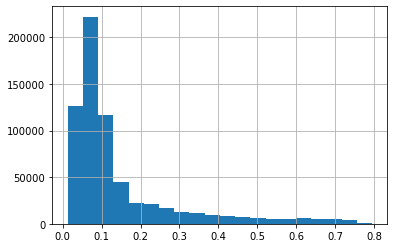

In [70]:
target_df["pred"] = oof_pred
display(target_df["pred"].hist(bins=20))

In [71]:
train = pd.read_csv("/kaggle/input/nfl-player-contact-detection/train_labels.csv")
train = pd.merge(train, target_df[["contact_id", "pred"]], on="contact_id", how="left")
train = train.fillna(0)
print(len(train))

def func(x_list):
    score = matthews_corrcoef(train['contact'], train["pred"]>x_list[0])
    return -score
x0 = [0.5]
result = minimize(func, x0,  method="nelder-mead")
opt_threshold = result.x[0]
score = round(matthews_corrcoef(train['contact'], train["pred"]>opt_threshold), 5)
threshold = round(opt_threshold, 5)
print(f"score:{score}, threshold:{threshold}")

del train

4721618
score:0.60536, threshold:0.33496


---

# Inference

In [72]:
CFG["features"] = FEATURE_COLS
CFG["threshold"] = threshold

In [73]:
test_df =pl.read_csv(CFG["TEST_LABEL_CSV"])
expand_cols = ["game_id", "play_id", "step", "nfl_player_id_1", "nfl_player_id_2"]
test_df = test_df.with_column([pl.col("contact_id").str.split_exact("_", 4)
                                    .struct.rename_fields(expand_cols).alias("key")]).unnest("key")
test_df = test_df.with_column(pl.concat_str([pl.col("game_id"),
                                             pl.col("play_id"),
                                             ], sep='_').alias('game_play'))
test_df = test_df.drop(["game_id", "play_id"])

print(len(test_df))

49588


## Merge tracking

In [74]:
FEATURE_TEST = ["nfl_player_id_1", "nfl_player_id_2", "step"]
tracking_df = pl.read_csv(CFG["TEST_TRACKING_CSV"])
test_df, FEATURE_TEST = target_merge_tracking(test_df, tracking_df, FEATURE_TEST)
test_df, FEATURE_TEST = create_trackmerged_ftr(test_df, FEATURE_TEST)
print(len(test_df))

del tracking_df

26
original length 49588
49588


## Exclude distance

In [75]:
test_df = test_df.filter(pl.col("players_dis") <= 2)
print(len(test_df))

6631


## Merge helmet

In [76]:
helmet_df = pl.read_csv(CFG["TEST_HELMET_CSV"])
test_df, FEATURE_TEST = target_merge_helmet(test_df, helmet_df, FEATURE_TEST)
test_df, FEATURE_TEST = get_categorical_ftr(test_df, FEATURE_TEST)
print(len(test_df))

del helmet_df

original length 6631
46
original length 6631
6631


In [77]:
test_df = test_df.to_pandas()
test_df["step"] = test_df["step"].astype(int)

In [78]:
models_path = glob.glob(os.path.join(CFG["EXP_DIR"], f'cat_fold*.model'))
print(len(models_path))
preds = []
for model_path in models_path:
    model = pickle.load(open(model_path, 'rb'))
    pred = np.array(model.predict_proba(test_df[CFG["features"]])[:, 1])
    preds.append(pred)
preds = np.mean(preds, axis=0)

5


<AxesSubplot:>

0    5833
1     798
Name: contact, dtype: int64


4254

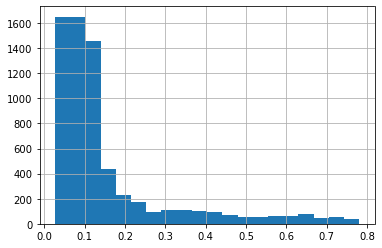

In [79]:
test_df["contact"] = preds
display(test_df["contact"].hist(bins=20))
test_df["contact"] = (test_df["contact"].values > CFG["threshold"]).astype(np.int)
test_df = test_df[["contact_id", "contact"]]
print(test_df["contact"].value_counts())
gc.collect()

In [80]:
!rm -rf /kaggle/working/EXP

In [81]:
sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')
print(len(sub))
sub = sub.drop("contact", axis=1).merge(test_df[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')
print(len(sub))
display(sub["contact"].value_counts())

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

49588
49588


0    48790
1      798
Name: contact, dtype: int64

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0
